In [71]:
from cmtj import CVector, Layer, Junction, AxialDriver, NullDriver
from cmtj.utils.resistance import calculate_resistance_parallel
from cmtj import constantDriver, sineDriver
from collections import defaultdict
from cmtj.utils import Filters

import matplotlib.pyplot as plt
import numpy as np
import cmtj
import math


OeToAm = 79.57747


Rx0 = 304.306  # @param {type: "number"}
Ry0 = 1.008  # @param {type: "number"}
SMR = -0.464  # @param {type: "number"}
AMR = -0.053  # @param {type: "number"}
AHE = -5.71  # @param {type: "number"}
w = 3e-5  # @param {type: "number"}
l = 2e-5  # @param {type: "number"}
INT_STEP = 1e-13  # @param {type: "number"}
HMIN = 250e3  # @param {type: "number"}
HMAX = 830e3  # @param {type: "number"}
HSTEPS = 100  # @param {type: "number"}


def compute_vsd1(stime, resistance, frequency, tstart=2e-9):
    """Time"""
    stime = np.asarray(stime)
    indx = np.argwhere(stime >= tstart).ravel()
    Rx = np.asarray(resistance)[indx]
    avg_res = np.mean(Rx)
    current = np.sqrt(1 / avg_res) * np.sin(2 * np.pi * frequency * stime[indx])
    return np.mean(current * Rx)


def compute_vsd2(dynamicR, integration_step, dynamicI):
    """Pymag"""
    SD = -dynamicI * dynamicR
    fs = 1.0 / integration_step
    SD_dc = Filters.butter_lowpass_filter(SD, cutoff=10e6, fs=fs, order=3)
    return np.mean(SD_dc)


def simulate_lorentz(Ms, Ku, frequency, orient, alpha=1e-4, Irf=0.5e-3):
    demagTensor = [
        CVector(0.0, 0.0, 0.0),
        CVector(0.0, 0.0, 0.0),
        CVector(0.0, 0.0, 1.0),
    ]
    thickness = 1.45e-9
    l1 = Layer(
        id="free",
        mag=CVector(0.0, 0.0, 1.0),
        anis=CVector(0, 0.0, 1.0),
        Ms=Ms,
        thickness=thickness,
        cellSurface=0,
        demagTensor=demagTensor,
        damping=alpha,
    )
    junction = Junction([l1])

    junction.setLayerAnisotropyDriver("free", constantDriver(Ku))

    HoeAmpl = 5000  # A/m
    Hspace = np.linspace(HMIN, HMAX, num=HSTEPS)
    theta = np.deg2rad(91)
    if orient == "4p":
        phideg = 0
    elif orient == "2p":
        phideg = 45
    else:
        raise ValueError("Unknown orient")
    phi = np.deg2rad(phideg)
    Hsweep = np.zeros((Hspace.shape[0]))
    for i, H in enumerate(Hspace):
        junction.clearLog()
        HDriver = AxialDriver(
            constantDriver(H * math.sin(theta) * math.cos(phi)),
            constantDriver(H * math.sin(theta) * math.sin(phi)),
            constantDriver(H * math.cos(theta)),
        )

        HoeDriver = AxialDriver(
            NullDriver(),
            NullDriver(),
            sineDriver(0, -HoeAmpl, frequency, 0),
        )
        junction.setLayerExternalFieldDriver("all", HDriver)
        junction.setLayerOerstedFieldDriver("all", HoeDriver)
        junction.runSimulation(40e-9, INT_STEP, INT_STEP, solverMode=cmtj.RK4)

        log = junction.getLog()
        m = np.asarray(
            [
                [log[f"{str_}_mx"], log[f"{str_}_my"], log[f"{str_}_mz"]]
                for str_ in ["free"]
            ]
        )
        dynamicRx, dynamicRy = calculate_resistance_parallel(
            Rx0=[Rx0],
            Ry0=[Ry0],
            AMR=[AMR],
            AHE=[AHE],
            SMR=[SMR],
            m=m,
            l=[l],
            w=[w],
        )
        dynamicR = dynamicRx if orient == "4p" else dynamicRy
        dynamicI = Irf * np.sin(2 * math.pi * frequency * np.asarray(log["time"]))
        vmix = compute_vsd2(dynamicR, INT_STEP, dynamicI)
        Hsweep[i] = vmix
    return Hspace, Hsweep


def simulate_lorentz_freq_scan(Ms, Ku, Hvalue, orient, alpha=1e-4, Irf=0.5e-3):
    demagTensor = [
        CVector(0.0, 0.0, 0.0),
        CVector(0.0, 0.0, 0.0),
        CVector(0.0, 0.0, 1.0),
    ]
    thickness = 1.45e-9
    l1 = Layer(
        id="free",
        mag=CVector(0.0, 0.0, 1.0),
        anis=CVector(0, 0.0, 1.0),
        Ms=Ms,
        thickness=thickness,
        cellSurface=0,
        demagTensor=demagTensor,
        damping=alpha,
    )
    junction = Junction([l1])

    junction.setLayerAnisotropyDriver("free", constantDriver(Ku))

    HoeAmpl = 5000  # A/m
    theta = np.deg2rad(91)
    if orient == "4p":
        phideg = 0
    elif orient == "2p":
        phideg = 45
    else:
        raise ValueError("Unknown orient")
    phi = np.deg2rad(phideg)
    fspace = np.arange(2, 18, 0.1) * 1e9
    fsweep = np.zeros((fspace.shape[0]))
    for i, f in enumerate(fspace):
        junction.clearLog()
        HDriver = AxialDriver(
            constantDriver(Hvalue * math.sin(theta) * math.cos(phi)),
            constantDriver(Hvalue * math.sin(theta) * math.sin(phi)),
            constantDriver(Hvalue * math.cos(theta)),
        )

        HoeDriver = AxialDriver(
            NullDriver(),
            NullDriver(),
            sineDriver(0, -HoeAmpl, f, 0),
        )
        junction.setLayerExternalFieldDriver("all", HDriver)
        junction.setLayerOerstedFieldDriver("all", HoeDriver)
        junction.runSimulation(40e-9, INT_STEP, INT_STEP, solverMode=cmtj.RK4)

        log = junction.getLog()
        m = np.asarray(
            [
                [log[f"{str_}_mx"], log[f"{str_}_my"], log[f"{str_}_mz"]]
                for str_ in ["free"]
            ]
        )
        dynamicRx, dynamicRy = calculate_resistance_parallel(
            Rx0=[Rx0],
            Ry0=[Ry0],
            AMR=[AMR],
            AHE=[AHE],
            SMR=[SMR],
            m=m,
            l=[l],
            w=[w],
        )
        dynamicR = dynamicRx if orient == "4p" else dynamicRy
        dynamicI = Irf * np.sin(2 * math.pi * f * np.asarray(log["time"]))
        vmix = compute_vsd2(dynamicR, INT_STEP, dynamicI)
        fsweep[i] = vmix
    return fspace, fsweep

In [72]:
from tqdm import tqdm
import multiprocess as mp
from functools import partial


def process_h(h, orient, irf, Ms, Ku, alpha):
    fscan, fsweep = simulate_lorentz_freq_scan(
        Ms, Ku, h, orient=orient, alpha=alpha, Irf=irf
    )
    if orient == "2p":
        fsweep -= fsweep.max()
    return fscan, fsweep


data = defaultdict(list)
hscans = []
vscans = []

hscan = np.arange(150, 650, 50) * 1e3
alpha = 30e-3  # @param {type: "number"}
Ms = 0.525  # @param {type: "number"}
Ku = 1.54e5  # @param {type: "number"}
orient = "2p"
irf = 0.4e-3
with mp.Pool() as pool:
    process_func = partial(process_h, orient=orient, irf=irf, Ms=Ms, Ku=Ku, alpha=alpha)
    results = list(tqdm(pool.imap(process_func, hscan), total=len(hscan)))

for fscan, fsweep in results:
    data[f"{orient}"].append(fsweep)
    data[f"{orient}-freq"].append(fscan)

100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


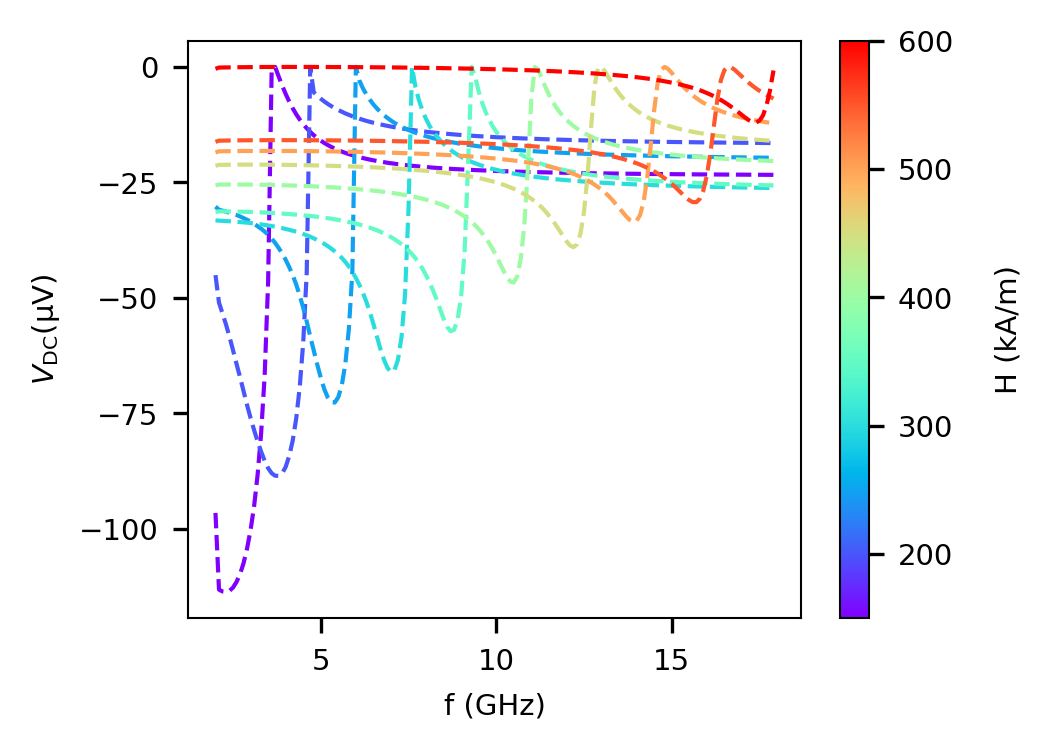

In [73]:
# import scienceplots

with plt.style.context(["nature"]):
    fig, ax = plt.subplots(dpi=300)

    colors = plt.get_cmap("rainbow")(np.linspace(0, 1, len(hscan)))
    for i, h in enumerate(hscan):
        ax.plot(
            np.asarray(data[f"{orient}-freq"][i]) / 1e9,
            np.asarray(data[orient][i]) * 1e6,
            alpha=1,
            linestyle="--", 
            label=f"{h/1e3:.2f} kA/m" if orient == "4p" else None,
            color=colors[i],
            linewidth=1,
        )
    # ax.set_xlim([300, 630])
    ax.set_ylabel(r"$V_\mathrm{DC} (\mathrm{\mu V})$")
    ax.set_xlabel("f (GHz)")

    # add a colorbar
    norm = plt.Normalize(min(hscan) / 1e3, max(hscan) / 1e3)
    sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label="H (kA/m)")
    cbar.ax.set_ylabel("H (kA/m)", rotation=90, labelpad=10)

    fig.align_ylabels([ax])
    # fig.legend()
    # fig.tight_layout()

In [10]:
from tqdm import tqdm

data = defaultdict(list)
hscans = []
vscans = []
fmin = 12  # @param {type: "number"}
fmax = 17  # @param {type: "number"}
fscan = [9, 12, 17, 22]
alpha = 30e-3  # @param {type: "number"}
Ms = 0.525  # @param {type: "number"}
Ku = 1.54e5  # @param {type: "number"}
for orient, irf in zip(("4p", "2p"), (0.75e-3, 0.4e-3)):
    for f in tqdm(fscan):
        hscan, vscan = simulate_lorentz(
            Ms, Ku, f * 1e9, orient=orient, alpha=alpha, Irf=irf
        )
        if orient == "2p":
            vscan -= vscan.max()
        data[f"{orient}"].append(vscan)
        data[f"{orient}-field"].append(hscan)

100%|██████████| 4/4 [01:35<00:00, 23.78s/it]


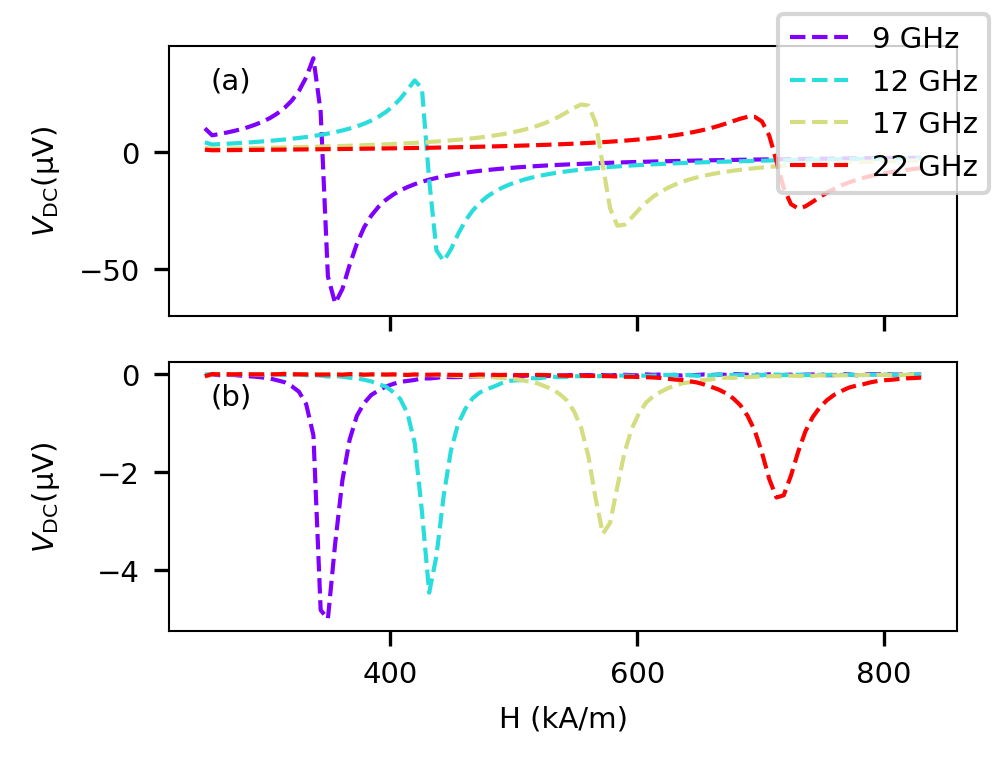

In [14]:
# import scienceplots

with plt.style.context(["nature"]):
    fig, ax = plt.subplots(2, 1, dpi=300, sharex="col")
    colors = plt.get_cmap("rainbow")(np.linspace(0, 1, len(fscan)))
    for j, orient in enumerate(("4p", "2p")):
        for i, f in enumerate(fscan):
            ax[j].plot(
                np.asarray(data[f"{orient}-field"][i]) / 1e3,
                np.asarray(data[orient][i]) * 1e6,
                alpha=1,
                linestyle="--",
                label=f"{f} GHz" if orient == "4p" else None,
                color=colors[i],
                linewidth=1,
            )
        # ax[j].set_xlim([300, 630])
        ax[j].set_ylabel(r"$V_\mathrm{DC} (\mathrm{\mu V})$")

    ax[1].set_xlabel("H (kA/m)")
    # ax[1].legend()
    import matplotlib.transforms as mtransforms

    # ax[0].legend()
    for label, ax_ in zip(["(a)", "(b)"], ax.flatten()):
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
        ax_.text(
            0.0,
            1.0,
            label,
            transform=ax_.transAxes + trans,
            fontsize="medium",
            verticalalignment="top",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )
    fig.subplots_adjust(hspace=0)
    fig.align_ylabels()
    fig.legend()
    fig.tight_layout()